In [1]:
import re
import regex
import pandas as pd
import numpy as np
 #import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
def startsWithDateAndTimeAndroid(s):
    #pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?([\u00A0\u202F]?(AM|PM|am|pm))? -'  
    result = re.match(pattern, s)
    
    if result:
        return True
    return False


In [3]:

def startsWithDateAndTimeios(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+) ([ ]?(AM|PM|am|pm))? -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [4]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [5]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message



In [6]:
def getDataPointios(line):
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
        date, time = dateTime.split(',')
    else:
        date, time = dateTime.split(' ')
    message = ' '.join(splitLine[1:])
    if FindAuthor(message):
        splitMessage = message.split(':')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    if time[5]==":":
        time = time[:5]+time[-3:]
    else:
        if 'AM' in time or 'PM' in time:
            time = time[:6]+time[-3:]
        else:
            time = time[:6]
    return date, time, author, message

In [7]:

parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'men.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None #message contains 4 things-"date","time","author","message" 
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line): 
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)



1/12/23, 8:44 AM - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [8]:
from datetime import datetime

def dateconv(date_string):
    input_format = '%m/%d/%y'
    output_format = '%Y-%m-%d'
    date = datetime.strptime(date_string, input_format)
    return date.strftime(output_format)

In [9]:

if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
         #df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        # df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [ ]:


df.head(2) #return first two rows of dataframe



In [ ]:
df.info()

In [ ]:

df.Author.unique() #returns all unique athors means all members of group

In [10]:
df = df.dropna() #drops all null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7069 entries, 1 to 7481
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      7069 non-null   datetime64[ns]
 1   Time      7069 non-null   object        
 2   Author    7069 non-null   object        
 3   Message   7069 non-null   object        
 4   urlcount  7069 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 331.4+ KB


In [11]:
total_messages = df.shape[0]
print(total_messages)

7069


In [12]:


media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)



0


In [ ]:
 #emojis = sum(df['emoji'].str.len()) 
 #print(emojis)

In [13]:


URLPATTERN = r'(https?://\S+)' #regex pattern matching with start with https
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len() #return url which matches with pattern and count it through lambda function
links = np.sum(df.urlcount) #sumup all the links
print(links)



80


In [14]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " You deleted this message")| (df["Message"] == " This message was deleted.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [15]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' '))) #word is calculated by spliting sentence by whitespace
messages_df["MessageCount"]=1

In [ ]:
messages_df.head(10)

In [ ]:


 #messages_df["emojicount"]= df['emoji'].str.len()



In [ ]:
frnds = messages_df.Author.unique()

for i in range(len(frnds)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == frnds[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {frnds[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == frnds[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
   #emojis = sum(req_df['emoji'].str.len())
   #print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(link_messages[link_messages['Author'] == frnds[i]]["urlcount"])   
  print('Links Sent', links)   
  print()

Text(0, 0.5, 'Time')

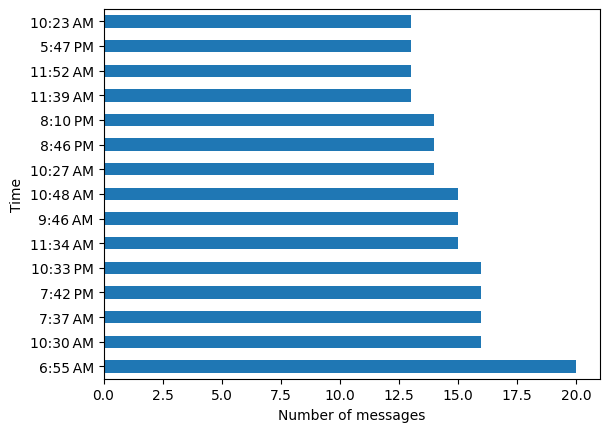

In [16]:
messages_df['Time'].value_counts().head(15).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

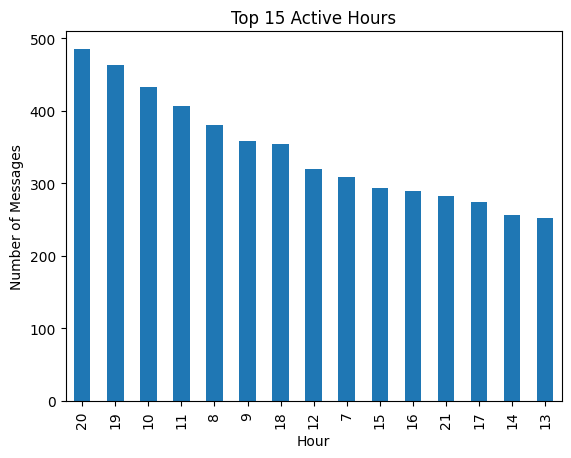

In [17]:
messages_df['Timehour'] = pd.to_datetime(messages_df['Time'])
messages_df['Hour'] = messages_df['Timehour'].dt.hour
hourly_message_counts = messages_df.groupby('Hour')['Message'].count()
top_10_active_hours = hourly_message_counts.sort_values(ascending=False).head(15)
top_10_active_hours.plot.bar()
plt.xlabel('Hour')
plt.ylabel('Number of Messages')
plt.title('Top 15 Active Hours')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


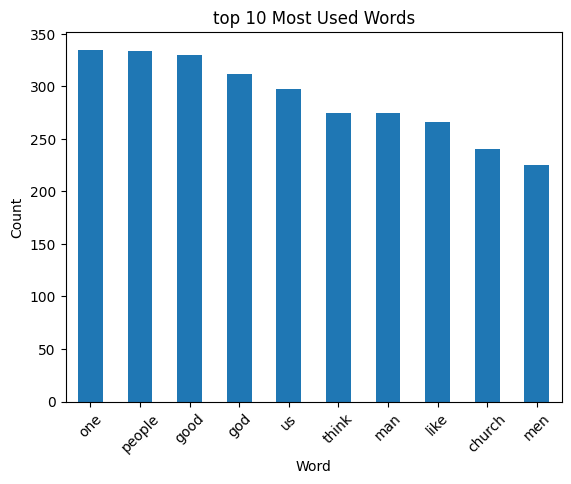

In [18]:
import nltk
# Download stopwords data
nltk.download('stopwords')

# Get stopwords for English language
stopwords = nltk.corpus.stopwords.words('english')



# Filter out stopwords from messages and count word frequencies
word_counts = pd.Series([word for msg in messages_df['Message'] for word in str(msg).lower().split() if word not in stopwords]).value_counts()

# Sort word frequencies in descending order
word_counts.sort_values(ascending=False, inplace=True)

# Get top 10 words
top_10_words = word_counts.head(10)

# Plot bar chart
top_10_words.plot.bar()
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('top 10 Most Used Words')

# Set x-tick labels to the top 10 words
plt.xticks(np.arange(10), top_10_words.index, rotation=45)

plt.show()


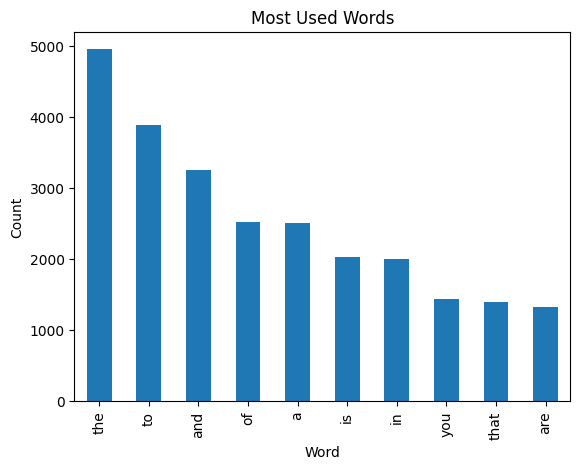

In [19]:
# Use list comprehension to create word_counts series
word_counts = pd.Series([word for msg in df['Message'] for word in msg.split()]).value_counts()

# Use inplace=True parameter for sorting
word_counts.sort_values(ascending=False, inplace=True)

# Get top 40 words
top_40_words = word_counts.head(10)

# Plot bar chart
top_40_words.plot.bar()
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Used Words')

# Use numpy.arange() instead of range()
plt.xticks(np.arange(10), top_40_words.index, rotation=90)

plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


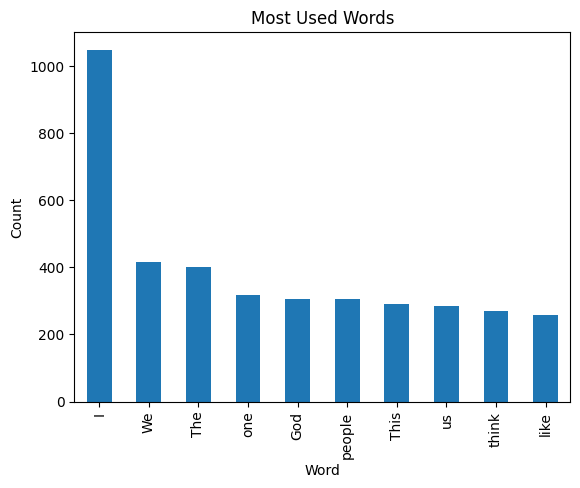

In [20]:

# Import NLTK library
import nltk

# Download stopwords data
nltk.download('stopwords')

# Get stopwords for English language
stopwords = nltk.corpus.stopwords.words('english')

# Filter them out from word_counts series
word_counts = pd.Series([word for msg in messages_df['Message'] for word in msg.split() if word not in stopwords]).value_counts()

# Use inplace=True parameter for sorting
word_counts.sort_values(ascending=False, inplace=True)

# Get top 40 words
top_40_words = word_counts.head(10)

# Plot bar chart
top_40_words.plot.bar()
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Used Words')

# Use numpy.arange() instead of range()
plt.xticks(np.arange(10), top_40_words.index, rotation=90)

plt.show()

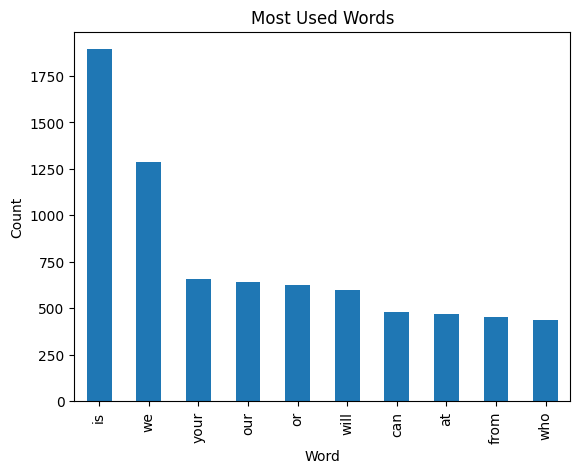

In [21]:
# Create a list of common words
stopwords = ['a','i','I','the','This','and','that','in','you','us','are','to','of','for','not','be','it','on','was','but','as','with','this','they','have']

# Filter them out from word_counts series
word_counts = pd.Series([word for msg in messages_df['Message'] for word in msg.split() if word not in stopwords]).value_counts()
# Use inplace=True parameter for sorting
word_counts.sort_values(ascending=False, inplace=True)

# Get top 40 words
top_40_words = word_counts.head(10)

# Plot bar chart
top_40_words.plot.bar()
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Used Words')
# Use numpy.arange() instead of range()
plt.xticks(np.arange(10), top_40_words.index, rotation=90)

plt.show()

There are 796871 words in all the messages.


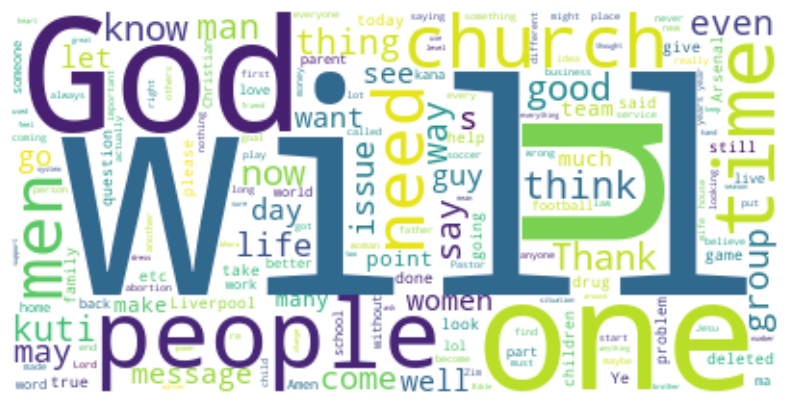

In [22]:


text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
# Get the frequency of each participant by Author column
author_freq = messages_df['Author'].value_counts()

# Sort the frequency in descending order
author_freq.sort_values(ascending=False, inplace=True)

# Get top 10 most active participants
top_10_authors = author_freq.head(15)

# Plot bar chart
top_10_authors.plot.bar()
plt.xlabel('Author')
plt.ylabel('Count')
plt.title('Most active Participants')

# Use numpy.arange() instead of range()
plt.xticks(np.arange(15),  rotation=90)

plt.show()

In [ ]:
# Group by Author column and count the number of messages
author_count = messages_df.groupby('Author')['Message'].count().sort_values(ascending=False)
top_ten_author= author_count.head(15)
plt.bar(top_ten_author.index,top_ten_author.values)
plt.xlabel('Numbers')
plt.ylabel('Number of messages')
plt.title('Number of Messages by Participant as at 03/05/23')
plt.xticks(rotation =45)
plt.show()

# Print the result
print(author_count.head(10))

In [ ]:
author_avg_length = messages_df.groupby('Author')['Message'].apply(lambda x: x.str.len().mean()).sort_values(ascending=False)
top_ten_author = author_avg_length.head(10)
print(top_ten_author)

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Calculate the top 40 most used words (excluding stopwords)
top_words = messages_df['Message'].str.split(expand=True).stack().value_counts()
top_words = top_words[~top_words.index.isin(stop_words)].head(40)

# Count the number of times each author uses the top words in their messages
author_top_word_count = messages_df.groupby('Author')['Message'].apply(lambda x: x.str.split(expand=True).stack().isin(top_words.index).sum())
top_ten_author = author_top_word_count.sort_values(ascending=False).head(10)
print(top_ten_author)